### What is this?

This isn't really a money machine, I'm just kidding about that, sorry.  

This is just a quick exploration of two awesome Python packages that I wanted to play with for a while

- [`Prophet`](https://facebookincubator.github.io/prophet) for time series forecasting
- [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/) for grabbing historic stock price data

Prophet seems like an awesome project by Facebook to make state-of-the-art time series forecasting really easy and simple. I've been hoping to give it a try for a while. 

I've also been itching to play aound with pandas-datareader, which makes it really grab data from multiple [remote datasources](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html), including historic stock prices from [Yahoo! Finance](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-yahoo)  

I decided to see how Prophet does at forecasting future stock prices based on historic data. Now, before you scold me about the fact that [what I'm doing is silly](https://en.wikipedia.org/wiki/Random_walk_hypothesis), I know, you can't really use this to predict stock prices, but time series forecasting can be useful for many other things.

Plus it never hurts to prove well known hypothesis to yourself, no matter how much it might seem like common knowledge. 

So I don't really expect to become a millionaire quite yet, but it's a fun little project to learn more about these awesome packages.

So let's get started!

### Enviroment

Docker, docker-compose and Jupyter is my preferred way of setting up a reproducible enviroment for analysis.

The [notebook](git@github.com:michael-erasmus/money-machine.git) for this analysis runs with Dockerfile I set up using Jupyters opinionated Docker images for datascience notebooks. 

Once I got everything up and running, I could 

In [261]:
#The usual suspects
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Plus some new interesting characters
from fbprophet import Prophet
import pandas_datareader.data as web

### Our data source

`pandas_datareader` makes it incredibly easy to get historic stock market data

For today we'll just get the daily closing prices of the S&P 500 (SPY)

We'll train on data from the start of 2000 to 2017-03-14
We'll use the last week's data as a holdout set to evaluate our model (up until 2017-03-21)

In [258]:
start = datetime.datetime(2000, 1,1)
end = datetime.datetime(2017, 3, 21)

train = web.DataReader("SPY", 'yahoo', start, end)
compare = train.copy()
train = train['2000-01-03': '2017-03-14']
train.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.4375,8164300,105.366938
2000-01-04,143.531204,144.062500,139.640594,139.7500,8089800,101.246443
2000-01-05,139.937500,141.531204,137.250000,140.0000,12177900,101.427563
2000-01-06,139.625000,141.500000,137.750000,137.7500,6227200,99.797478
2000-01-07,140.312500,145.750000,140.062500,145.7500,8066500,105.593338


### Can we forecast future prices?


This is where we get to play with Prophet. First we'll prepare our dataset in a way that Prophet likes it.

In [260]:
df = pd.DataFrame({'ds': train.index, 'y': train['Adj Close']}).reset_index()

df = df.drop('Date', axis=1)
df.head()

,ds,y
0,2000-01-03,105.366938
1,2000-01-04,101.246443
2,2000-01-05,101.427563
3,2000-01-06,99.797478
4,2000-01-07,105.593338


Now we can train our model. Since we don't expect stock prices to really follow a weekly seasonality we'll switch that off.

In [230]:
m = Prophet(weekly_seasonality=False)
m.fit(df);

To be able to make forecasts on future dates we can use a handy helper method to generate our expected input 

In [231]:
future = m.make_future_dataframe(periods=365)

Finally we can make our prediction, using probably the coolest line of code I've ever written

In [ ]:
forecast = m.predict(future)

### Let's see how that did! 

We can use our `compare` dataframe from earlier to see how our forecasted value for yesterday's price compares to the actual price

In [253]:
forecasted = forecast.set_index('ds').loc['2017-3-21'][['yhat', 'yhat_lower', 'yhat_upper']]
real = compare.loc['2017-03-21']['Adj Close']
print("Yesterday's Forecast:" )
print("{0:.2f} lower: {1:.2f}, upper: {2:.2f}, ".format(forecasted['yhat'], forecasted['yhat_lower'], forecasted['yhat_upper']))
print("\nReal:" )
print(real)

print('\nNext year''s Forecast:')

forecast.tail(1)[['ds','yhat', 'yhat_lower', 'yhat_upper']]

Yesterday's Forecast:
223.96 lower: 217.59, upper: 230.57, 

Real:
233.729996

Next years Forecast:


,ds,yhat,yhat_lower,yhat_upper
4695,2018-03-21,240.154202,222.598807,257.298648


Hmm, seems to be underestimating the actual price by quite a bit, however we're still within Prophet's 80% confidence interval.

Did I mention this isn't acually a valid technique for making investment decisions?

That being said, let's plot our performance, which again is made pretty easy by Prophet.

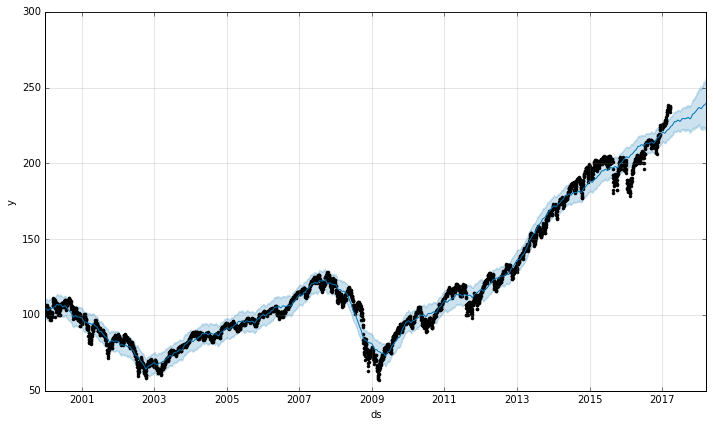

In [255]:
p = m.plot(forecast)

### Ok, see we didn't do too great, what can we learn?

Another really nice thing about Prophet is that it's really easy to plot the components of your forecasts (trend, yearly and/or weekly seasonality). Often this is a pretty useful tool for analysis by itself. 

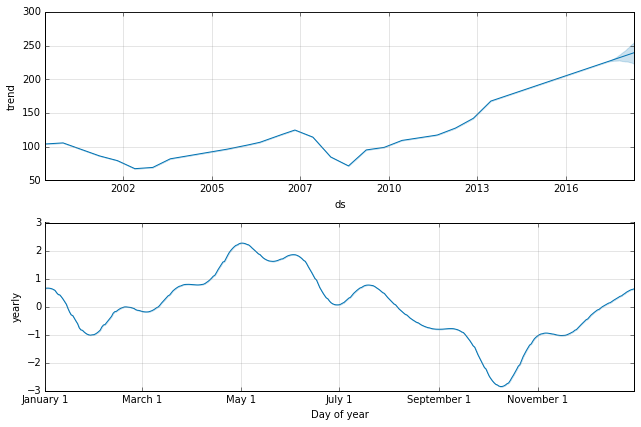

In [256]:
p = m.plot_components(forecast)

From the top chart we can clearly see that we've had one of the [longest bull runs in history](http://fortune.com/2017/03/09/stock-market-bull-market-longest/), which is pretty crazy, and our model thinks things can only go up from here. This is because of one of the fundamental underpinnings of time series forecasting. 

The market, like other time series, will have points where the general trend changes drastically. These are called [change points](https://en.wikipedia.org/wiki/Change_detection) and a good forecasting algorithm needs to detect change points to be able to model the trend in the data. Change points are not caused by general cycles in the data either (seasonality), which can be predicted with more accuracy. 

In fact, the one thing that any forecasting algorithm cannot predict is when the next change point will be, and how what effect that will have on the trend. This is also the flaw of my money machine. The market is a [random walk](https://en.wikipedia.org/wiki/Random_walk_hypothesis), and even though we know everything about historic price trends, we can't know when trends change. 


What's really interesting though is looking at yearly seasonality plot. From this plot it does seem like there is a strong seasonality in growth rates of stock prices throughout the year. We see a peak around May 1st, a decline up until late October, after which prices seem to trend up again.

This is a well known trading adage to [Sell in May and go away](https://en.wikipedia.org/wiki/Sell_in_May), but looking at the data, it seems to hold up quite well and might just be a good trading strategy. So maybe I have just a built a Money Machine after all! 

Then again, I'm sure if it was that simple we would have many more self made millionaires in the stock market. From [Investopedia](http://www.investopedia.com/terms/s/sell-in-may-and-go-away.asp#ixzz4c79c6mNF):

> There are limitations to implementing this strategy in practice, such as added transaction costs and tax implications of the rotation in and out of equities. Another drawback is that market timing and seasonality strategies do not always work out, and the actual results may be very different from the theoretical ones.

So please don't bet the farm quite yet!

### Conclusion

This was a fun little test of Prophet and pandas_datareader. 

pandas_datareader makes the normally tedious task of finding, downloading, reading and transforming finance data into a dataframe incredibly easy.

Prophet makes time series forecasting super simple, and it works with Python and R! It feels like a great tool in my analytics toolbox and I've just scratched the surface of what it can do

- [Logistic growth modelling](https://facebookincubator.github.io/prophet/docs/forecasting_growth.html)
- [Controlling changepoint detection and confidence](https://facebookincubator.github.io/prophet/docs/trend_changepoints.html)
- [Specifying holidays to control for holiday effects](https://facebookincubator.github.io/prophet/docs/holiday_effects.html)
- [Modelling uncertainty](https://facebookincubator.github.io/prophet/docs/uncertainty_intervals.html)
- [Dealing with outliers](https://facebookincubator.github.io/prophet/docs/outliers.html)